In [3]:
#Packages loading
import cv2 as cv # OpenCV
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import interactive
import math
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from kneed import KneeLocator
fig = plt.figure()
ax = plt.axes(projection='3d')
interactive(True)
# To see the images in a notebook:
%matplotlib inline

In [4]:
import geopandas as gpd
import folium
from sentinelsat import SentinelAPI
import rasterio as rio
from rasterio.mask import mask
import matplotlib.pyplot as plt
from matplotlib import cm
from rasterio import plot
from zipfile import ZipFile
from os import walk
from shapely.geometry import MultiPolygon, Polygon
import shutil
from os import makedirs
from time import time
import numpy as np
import cv2 as cv
import glob
import os
from osgeo import gdal

c:\Users\lenovo\Anaconda3\envs\plbd14\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

#Image loading
crop_img = {}
crop_img["RGB"] = cv.cvtColor(cv.imread('C:/Users/lenovo/Desktop/PMOO/interface-1/interface/sentinel2/'), cv.COLOR_BGR2RGB)
crop_img["NDVI"] = cv.cvtColor(cv.imread("/content/18_NDVI.png"), cv.COLOR_BGR2RGB)
crop_img["NDWI"] = cv.cvtColor(cv.imread("/content/18_NDWI.png"), cv.COLOR_BGR2RGB)

im_shape = crop_img["RGB"].shape[0:2]



error: OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


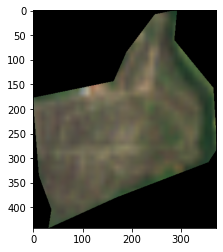

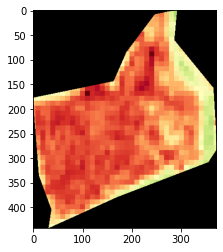

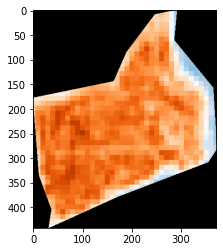

In [ ]:

for img in crop_img.values():
  plt.figure(figsize=(4,4))
  plt.imshow(img)
plt.show()

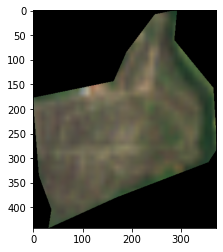

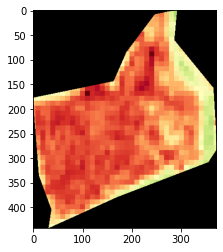

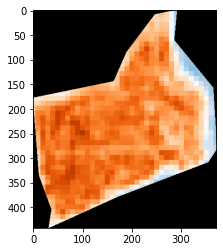

In [ ]:

#Image plot

for key in crop_img.keys():
  plt.figure(figsize=(4,4))
  #crop_img[key][:,:,0][crop_img[key][:,:,0] != 0] = (crop_img[key][:,:,0][crop_img[key][:,:,0] != 0] - crop_img[key][:,:,0][crop_img[key][:,:,0] != 0].mean())/crop_img[key][:,:,0][crop_img[key][:,:,0] != 0].std()
  #crop_img[key][:,:,1][crop_img[key][:,:,1] != 0] = (crop_img[key][:,:,1][crop_img[key][:,:,1] != 0] - crop_img[key][:,:,1][crop_img[key][:,:,1] != 0].mean())/crop_img[key][:,:,1][crop_img[key][:,:,1] != 0].std()
  #crop_img[key][:,:,2][crop_img[key][:,:,2] != 0] = (crop_img[key][:,:,2][crop_img[key][:,:,2] != 0] - crop_img[key][:,:,2][crop_img[key][:,:,2] != 0].mean())/crop_img[key][:,:,2][crop_img[key][:,:,2] != 0].std()

  #crop_img[key][crop_img[key] != 0] = (crop_img[key][crop_img[key] != 0] - crop_img[key][crop_img[key] != 0].mean())/crop_img[key][crop_img[key] != 0].std()

  #crop_img[key][:,:,0] = crop_img[key] / np.max(crop_img[key])

  plt.imshow(crop_img[key])

plt.show()

In [ ]:

rgb_vector = np.concatenate([crop_img["RGB"][:,:,0].flatten().reshape(1,-1),crop_img["RGB"][:,:,1].flatten().reshape(1,-1),crop_img["RGB"][:,:,2].flatten().reshape(1,-1)], axis=0)
ndvi_vector = np.concatenate([crop_img["NDVI"][:,:,0].flatten().reshape(1,-1), crop_img["NDVI"][:,:,1].flatten().reshape(1,-1), crop_img["NDVI"][:,:,2].flatten().reshape(1,-1)], axis=0)
ndwi_vector = np.concatenate([crop_img["NDWI"][:,:,0].flatten().reshape(1,-1), crop_img["NDWI"][:,:,1].flatten().reshape(1,-1), crop_img["NDWI"][:,:,2].flatten().reshape(1,-1)], axis=0)

#ndvi_vector[ndvi_vector != 0] = (ndvi_vector[ndvi_vector != 0] - ndvi_vector[ndvi_vector != 0].mean())/ndvi_vector[ndvi_vector != 0].std()
#ndwi_vector[ndwi_vector != 0] = (ndwi_vector[ndwi_vector != 0] - ndwi_vector[ndwi_vector != 0].mean())/ndwi_vector[ndwi_vector != 0].std()

X = np.concatenate([ndvi_vector, ndwi_vector], axis = 0)


eigenvalues:  [125323.11593052  28657.66211312   8174.49277654   3164.48519116
   2296.93000219   1117.07545014]
[-2.97201694e-11 -8.77971415e-12 -1.21789036e-13 ... -3.91577927e+02
 -3.91577927e+02 -3.91577927e+02]


<Figure size 1800x1800 with 0 Axes>

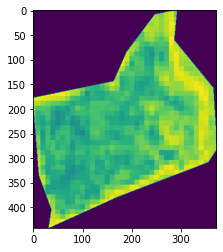

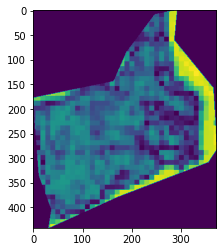

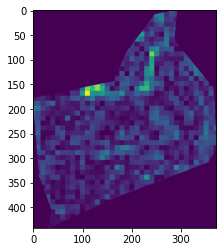

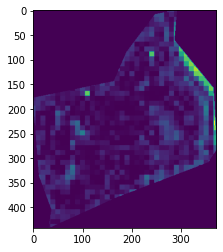

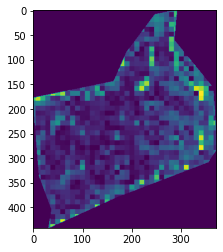

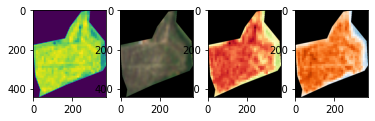

In [ ]:

plt.figure(figsize=(25,25))

U, S, V = np.linalg.svd(X.T, full_matrices=False)
vp = S.flatten()
print('eigenvalues: ', vp)

nouvelle_cartographie = np.zeros(im_shape[0] * im_shape[1])
for i in range(len(vp)):
  nouvelle_cartographie = nouvelle_cartographie +  vp[i] * U[:, i]
  plt.figure()
  plt.imshow(np.maximum(np.abs(vp[i] * U[:, i].reshape(im_shape)), 0))
print(nouvelle_cartographie[nouvelle_cartographie !=0])
nouvelle_cartographie = nouvelle_cartographie/np.max(nouvelle_cartographie)
nouvelle_cartographie =np.abs(nouvelle_cartographie.reshape(im_shape)).reshape(im_shape) / np.amax(np.abs(nouvelle_cartographie))

plt.subplot(1,4,1)
plt.imshow(nouvelle_cartographie)
plt.subplot(1,4,2)
plt.imshow(crop_img["RGB"])
plt.subplot(1,4,3)
plt.imshow(crop_img["NDVI"])
plt.subplot(1,4,4)
plt.imshow(crop_img["NDWI"])
a = nouvelle_cartographie

In [ ]:

def sentinel2_processing(nom_shp):
    ''' traite les images satellites precedemment telechargees de la zone shapefile : applique un masque et calcul le ndvi'''
    temps_process = str(time())+'_' #la date qu on mettra dans le nom de l'image
    nReserve = gpd.read_file(Main_dossier + 'layers/'+nom_shp)
    nReserve.set_crs(epsg=4326, inplace=True)

    zip_file = ''
    for (dirpath, dirnames, filenames) in walk(Main_dossier+'S2_downloads/'):
        for nom in filenames :
            if 'S2' in nom:
                zip_file = nom
    with ZipFile(Main_dossier+'S2_downloads/'+zip_file, 'r') as zip:
        zip.extractall(Main_dossier+'S2_downloads')

    # files folders
    l1 = ''
    for (dirpath, dirnames, filenames) in walk(Main_dossier+'S2_downloads/'):
        if dirnames != []:
            if 'L2A' in dirnames[0]:
                l1 = dirnames[0]
    product_title = zip_file[0:len(zip_file)-4] #on retire l'extension .zip

    R10 = product_title + '.SAFE/GRANULE/'+l1+'/IMG_DATA/R10m/'

    b4 = ''
    b3 = ''
    b2 = ''
    b8 = ''
    tcl = ''


    for (dirpath, dirnames, filenames) in walk(Main_dossier+'S2_downloads/'+R10):
        for nom in filenames :
            if 'B04' in nom:
                b4 = nom
            if 'B03' in nom:
                b3 = nom
            if 'B02' in nom:
                b2 = nom
            if 'B08' in nom:
                b8 = nom
            if 'TCI' in nom:
                tcl = nom


    # Open b4 and b8
    b4 = rio.open(Main_dossier+'S2_downloads/'+R10+b4,driver = 'JP2OpenJPEG')
    b3 = rio.open(Main_dossier+'S2_downloads/'+R10+b3,driver = 'JP2OpenJPEG')
    b2 = rio.open(Main_dossier+'S2_downloads/'+R10+b2,driver = 'JP2OpenJPEG')
    b8 = rio.open(Main_dossier+'S2_downloads/'+R10+b8,driver = 'JP2OpenJPEG')
    tlc =rio.open(Main_dossier+'S2_downloads/'+R10+tcl,driver = 'JP2OpenJPEG')

    # write true color

    trueColor =rio.open(Main_dossier+'S2_downloads/'+'SentienelTrueColor.tiff','w',driver='Gtiff',width = b4.width, height = b4.height, count=3,crs =b4.crs,transform = b4.transform, dtype = b4.dtypes[0]) #count : 3 bands

    trueColor.write(b2.read(1),3) #.read(1) donne la matrice #blue
    trueColor.write(b3.read(1),2) #green
    trueColor.write(b4.read(1),1) #red
    trueColor.close()

    # write the NDVI image
    red = b4.read()
    nir = b8.read()
    ndvi = (nir.astype(float)-red.astype(float))/(nir.astype(float)+red.astype(float))

    meta = b4.meta
    meta.update(driver='GTiff')
    meta.update(dtype=rio.float32)

    with rio.open(Main_dossier+'S2_downloads/'+'NDVI.tiff', 'w', **meta) as dst:
        dst.write(ndvi.astype(rio.float32))

    # write the NDWI image
    green = b3.read()
    ndwi = (green.astype(float)-nir.astype(float))/(nir.astype(float)+green.astype(float))
    with rio.open(Main_dossier+'S2_downloads/'+'NDWI.tiff', 'w', **meta) as dst:
        dst.write(ndwi.astype(rio.float32))

    # mask

    nReserve_proj = nReserve.to_crs({'init': str(b4.crs)}) # met la forme geometrique au meme format que l'image satellite

    # mask on ndvi

    with rio.open(Main_dossier+'S2_downloads/'+'NDVI.tiff') as src:
        out_image, out_transform = mask(src, nReserve_proj.geometry, crop=True, invert = False) #
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform})

    with rio.open(Main_dossier+'NDVI_images/'+temps_process+"NDVI_masked.tiff", "w", **out_meta) as dest:
        dest.write(out_image)


    # mask on ndwi

    with rio.open(Main_dossier+'S2_downloads/'+'NDWI.tiff') as src:
        out_image, out_transform = mask(src, nReserve_proj.geometry, crop=True, invert = False) #
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform})

    with rio.open(Main_dossier+'NDWI_images/'+temps_process+"NDWI_masked.tiff", "w", **out_meta) as dest:
        dest.write(out_image)

    # mask on true color

    with rio.open(Main_dossier+'S2_downloads/'+'SentienelTrueColor.tiff') as src:
        out_image, out_transform = mask(src, nReserve_proj.geometry, crop=True, invert = False) #
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform})

    with rio.open(Main_dossier+'RGB_images/'+temps_process+"RGB_masked.tiff", "w", **out_meta) as dest:
        dest.write(out_image)


    # PNG on True Color
    dataset = gdal.Open(Main_dossier+'RGB_images/'+temps_process+'RGB_masked.tiff')
    print(dataset.RasterCount)

    band1 = dataset.GetRasterBand(1) # Red channel
    band2 = dataset.GetRasterBand(2) # Green channel
    band3 = dataset.GetRasterBand(3) # Blue channel

    b1 = band1.ReadAsArray()
    b2 = band2.ReadAsArray()
    b3 = band3.ReadAsArray()

    b1n =(b1-np.amin(b1))/(np.amax(b1)-np.amin(b1)) #*2,5 ?
    b2n =(b2-np.amin(b2))/(np.amax(b2)-np.amin(b2))
    b3n =(b3-np.amin(b3))/(np.amax(b3)-np.amin(b3))


    img = np.dstack((b1n, b2n, b3n))
    f = plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.savefig(Main_dossier+'RGB_images/'+temps_process+'RGB_masked.png',bbox_inches='tight', transparent=True, pad_inches=0)


    # PNG on NDVI
    out_image = rio.open(Main_dossier+'NDVI_images/'+temps_process+"NDVI_masked.tiff")
    f = plt.figure()
    plt.axis('off')
    plt.imshow(out_image.read(1), cmap="RdYlGn")
    plt.savefig(Main_dossier+'NDVI_images/'+temps_process+"NDVI_masked.png",bbox_inches='tight', transparent=True, pad_inches=0)

    # PNG on NDWI
    out_image = rio.open(Main_dossier+'NDWI_images/'+temps_process+"NDWI_masked.tiff")
    f = plt.figure()
    plt.imshow(out_image.read(1), 'RdYlBu')
    plt.axis('off')
    plt.savefig(Main_dossier+'NDWI_images/'+temps_process+"NDWI_masked.png",bbox_inches='tight', transparent=True, pad_inches=0)
    crop_img = {}
    crop_img["RGB"] = cv.cvtColor(cv.imread(Main_dossier+'RGB_images/'+temps_process+'RGB_masked.png'), cv.COLOR_BGR2RGB)
    crop_img["NDVI"] = cv.cvtColor(cv.imread(Main_dossier+'NDVI_images/'+temps_process+"NDVI_masked.png"), cv.COLOR_BGR2RGB)
    crop_img["NDWI"] = cv.cvtColor(cv.imread(Main_dossier+'NDWI_images/'+temps_process+"NDWI_masked.png"), cv.COLOR_BGR2RGB)
    
    im_shape = crop_img["RGB"].shape[0:2]
    for img in crop_img.values():
        plt.figure(figsize=(4,4))
        plt.imshow(img)
    plt.show()


eigenvalues:  [125323.11593052  28657.66211312   8174.49277654   3164.48519116
   2296.93000219   1117.07545014]
[-2.97201694e-11 -8.77971415e-12 -1.21789036e-13 ... -3.91577927e+02
 -3.91577927e+02 -3.91577927e+02]


<Figure size 1800x1800 with 0 Axes>

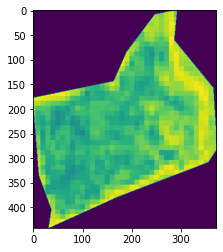

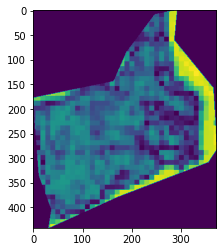

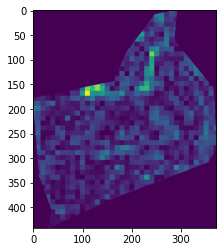

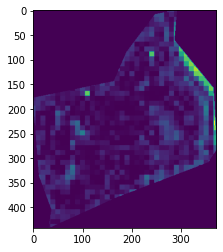

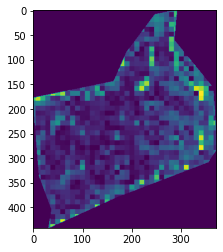

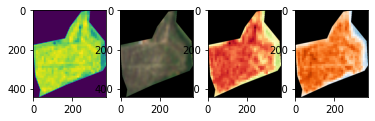

In [ ]:

plt.figure(figsize=(25,25))

U, S, V = np.linalg.svd(X.T, full_matrices=False)
vp = S.flatten()
print('eigenvalues: ', vp)

nouvelle_cartographie = np.zeros(im_shape[0] * im_shape[1])
for i in range(len(vp)):
  nouvelle_cartographie = nouvelle_cartographie +  vp[i] * U[:, i]
  plt.figure()
  plt.imshow(np.maximum(np.abs(vp[i] * U[:, i].reshape(im_shape)), 0))
print(nouvelle_cartographie[nouvelle_cartographie !=0])
nouvelle_cartographie = nouvelle_cartographie/np.max(nouvelle_cartographie)
nouvelle_cartographie =np.abs(nouvelle_cartographie.reshape(im_shape)).reshape(im_shape) / np.amax(np.abs(nouvelle_cartographie))

plt.subplot(1,4,1)
plt.imshow(nouvelle_cartographie)
plt.subplot(1,4,2)
plt.imshow(crop_img["RGB"])
plt.subplot(1,4,3)
plt.imshow(crop_img["NDVI"])
plt.subplot(1,4,4)
plt.imshow(crop_img["NDWI"])

nouvelle_cartographie = np.uint8(nouvelle_cartographie * 255)

In [ ]:
nouvelle_cartographie

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

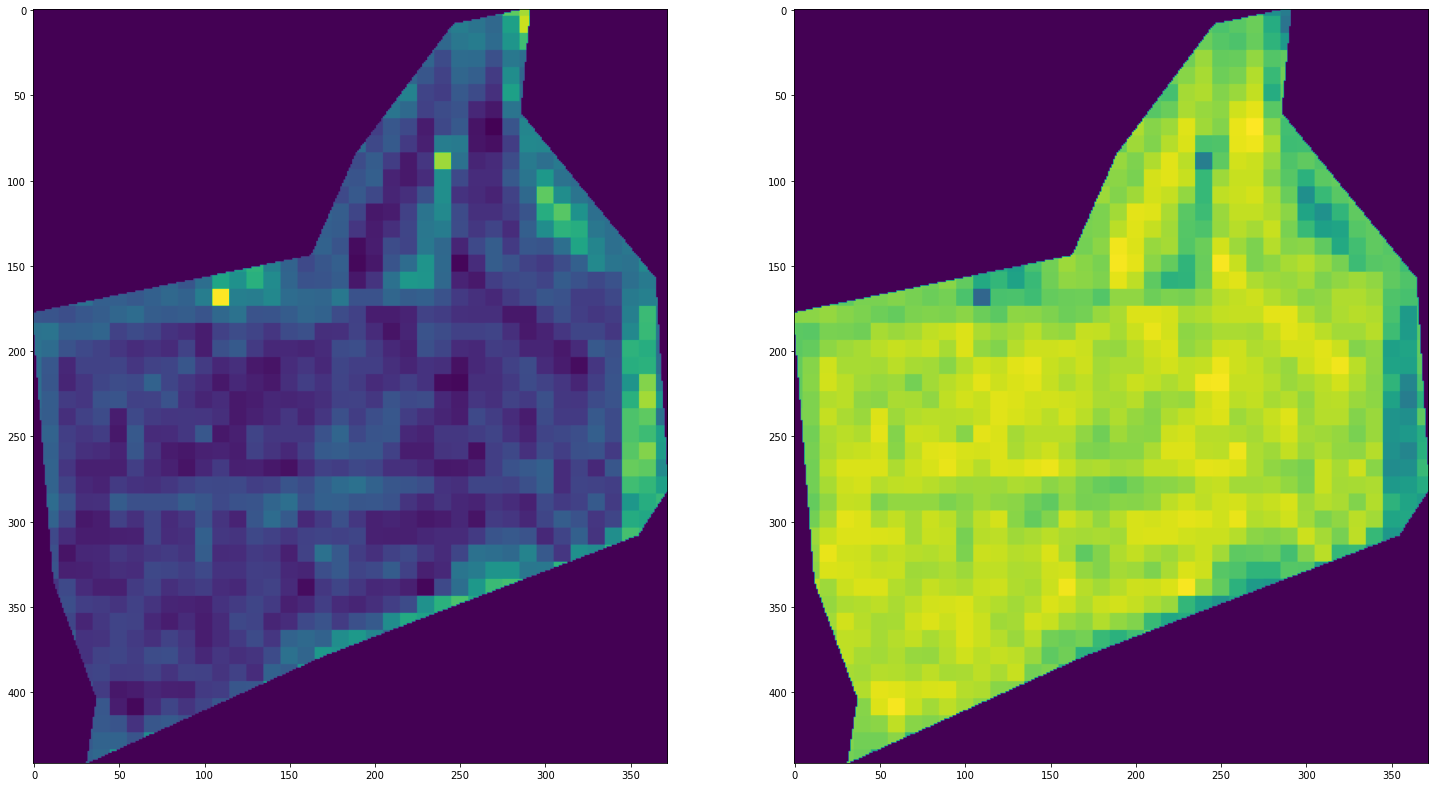

In [ ]:
plt.figure(figsize=(25,25))
plt.subplot(1,2,1)
plt.imshow(-nouvelle_cartographie)
plt.subplot(1,2,2)
plt.imshow(nouvelle_cartographie)

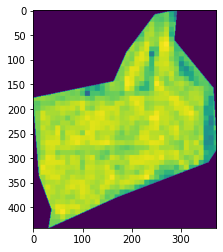

In [ ]:
plt.imshow(nouvelle_cartographie)

In [ ]:
#Superpixels clustering : 
slic_alg = cv.ximgproc.createSuperpixelSLIC(nouvelle_cartographie,algorithm = cv.ximgproc.SLICO, region_size = 20)
slic_alg.iterate(15)
supPix_contour_mask = slic_alg.getLabelContourMask()
den_crop_img_segm_SupPix = nouvelle_cartographie.copy()
den_crop_img_segm_SupPix[supPix_contour_mask == 255] = np.full(den_crop_img_segm_SupPix[supPix_contour_mask == 255].shape, [255])


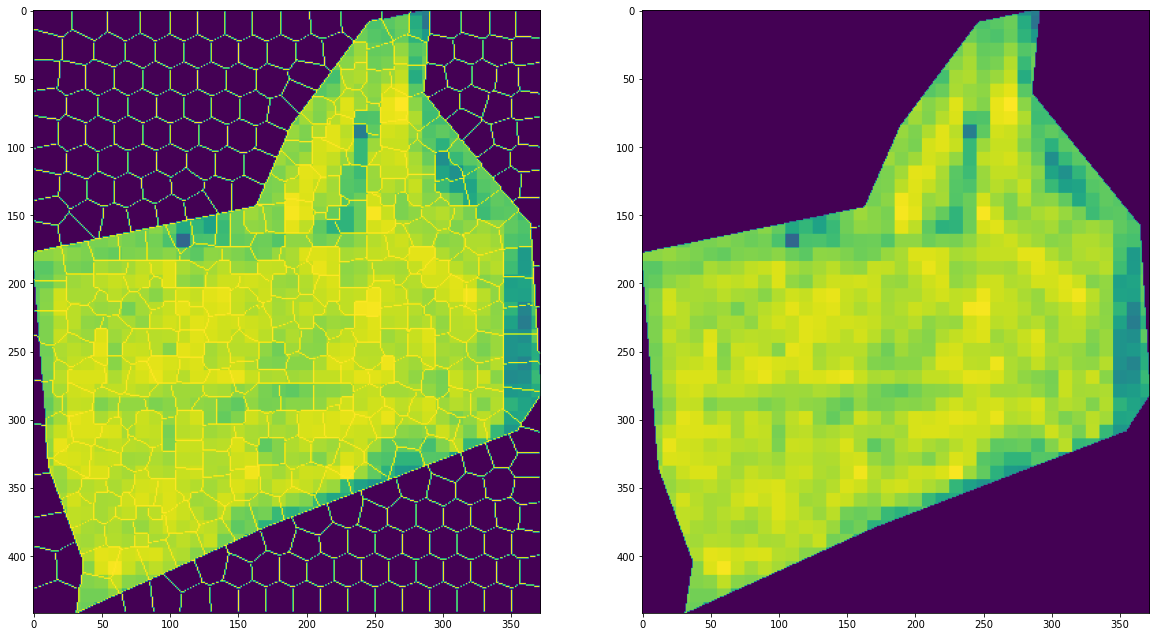

In [ ]:

figure, ax = plt.subplots(1,2)
figure.set_size_inches((20,15))
ax[0].imshow(den_crop_img_segm_SupPix)
ax[1].imshow(nouvelle_cartographie)

plt.show()

In [ ]:

labels = slic_alg.getLabels()
n = slic_alg.getNumberOfSuperpixels()
print(n, "Superpixels")

den_crop_img_segm_SupPix_mean = np.zeros(den_crop_img_segm_SupPix.shape)
for i in range(0, n+2):
  den_crop_img_segm_SupPix_mean[labels == i] = np.full(den_crop_img_segm_SupPix_mean[labels == i].shape, np.clip(nouvelle_cartographie[labels == i].mean(axis = 0), 1, 250))

den_crop_img_segm_SupPix_mean = np.uint8(den_crop_img_segm_SupPix_mean)


407 Superpixels


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


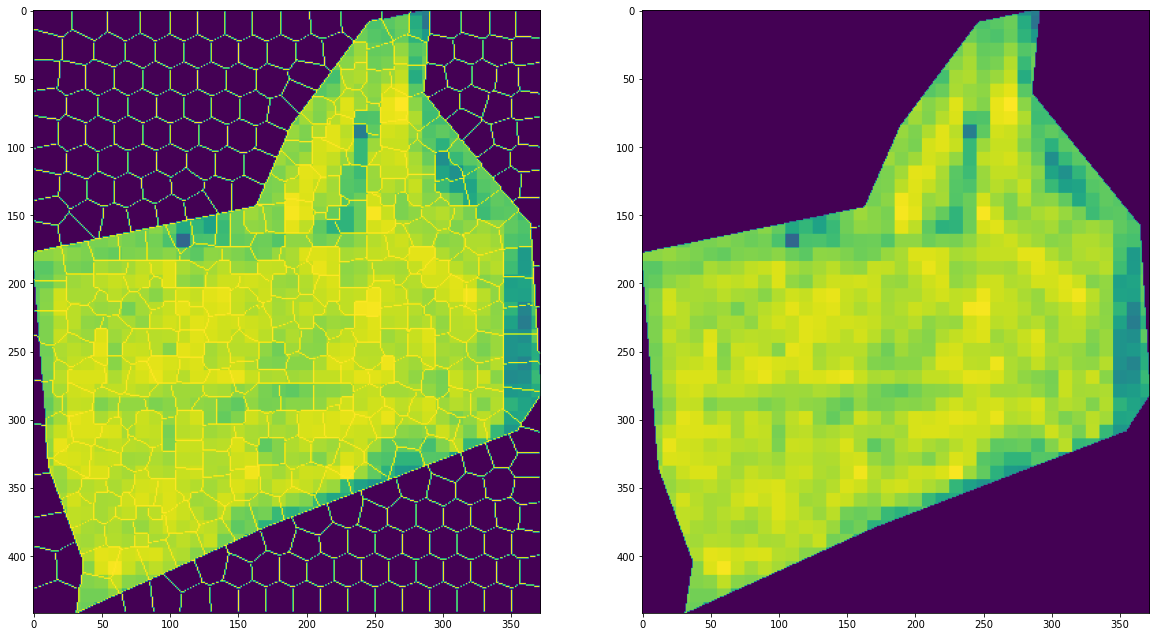

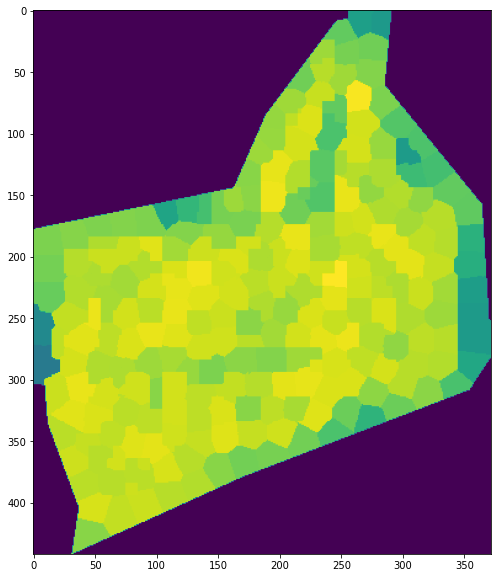

In [ ]:

figure, ax = plt.subplots(1,2)
figure.set_size_inches((20,15))
ax[0].imshow(den_crop_img_segm_SupPix)
ax[1].imshow(nouvelle_cartographie)

plt.show()
plt.figure(figsize=(10,10))
plt.imshow(den_crop_img_segm_SupPix_mean)

In [ ]:

supPix_means = np.float32(np.asarray([nouvelle_cartographie[labels == i].mean(axis = 0) for i in range(n)]))
supPix_centers = np.float32( [np.argwhere(labels == i).mean(axis = 0) for i in range(n)])


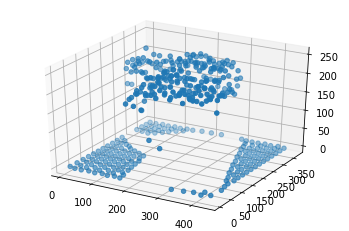

In [ ]:

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(supPix_centers[:, 0], supPix_centers[:, 1], supPix_means)

In [ ]:

Kmax = 10
compactness = []
scale = 0.0
from sklearn.preprocessing import MinMaxScaler
Z = np.append((supPix_means.reshape(-1, 1) - supPix_means.mean())/supPix_means.std() , scale * (supPix_centers -  supPix_centers.mean())/ supPix_centers.std(), axis = 1).reshape((-1,3))
Z = np.float32(Z)
for K in range(2, Kmax):
  km = KMeans(n_clusters=K, random_state=0).fit(Z)
  ret = km.inertia_

  compactness.append(ret)
  # Now convert back into uint8, and make original image


In [ ]:

gm_bic= []
gm_score=[]
K_final = 2
temp = 0
K_found = False
for i in range(2,Kmax):
    gm = GaussianMixture(n_components=i,n_init=10,tol=1e-3,max_iter=1000).fit(Z)
    print("BIC for number of cluster(s) {}: {}".format(i,gm.bic(Z)))
    print("Log-likelihood score for number of cluster(s) {}: {}".format(i,gm.score(Z)))
    print("-"*100)
    gm_bic.append(-gm.bic(Z))
    gm_score.append(gm.score(Z))
    if np.log(-gm.bic(Z)) <  temp and K_found == False:
      K_final = i - 1
      K_found = True

    temp = np.log(-gm.bic(Z))

BIC for number of cluster(s) 2: -11171.140026802439
Log-likelihood score for number of cluster(s) 2: 13.864014099908905
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 3: -11227.841026018825
Log-likelihood score for number of cluster(s) 3: 14.007489690904988
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 4: -11188.811165033345
Log-likelihood score for number of cluster(s) 4: 14.0333598025376
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 5: -11133.572040914965
Log-likelihood score for number of cluster(s) 5: 14.039316814498344
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 6: -11077.055569164257
Log-likelihood score for number of cluster(s) 6: 14.04370460332355

In [ ]:
K_final

3

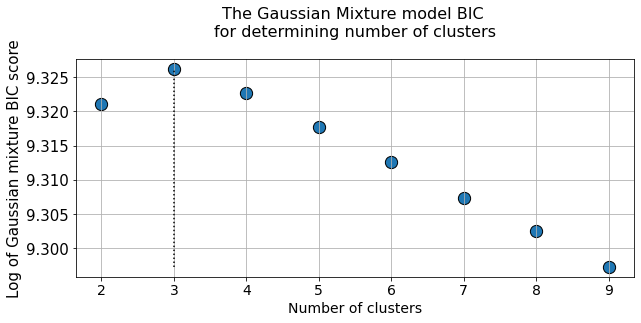

In [ ]:
plt.figure(figsize=(Kmax,4))
plt.title("The Gaussian Mixture model BIC \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,Kmax)],y=np.log(gm_bic),s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Log of Gaussian mixture BIC score",fontsize=15)
plt.xticks([i for i in range(2,Kmax)],fontsize=14)
plt.yticks(fontsize=15)

plt.vlines(K_final, min(np.log(gm_bic)), max(np.log(gm_bic)), linestyles="dotted")


plt.show()

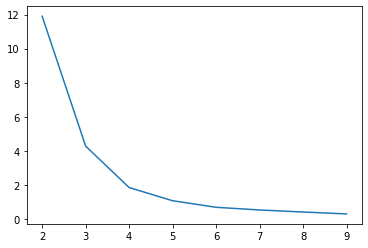

In [ ]:
plt.plot([i for i in range(2,Kmax)], compactness[0::])

4


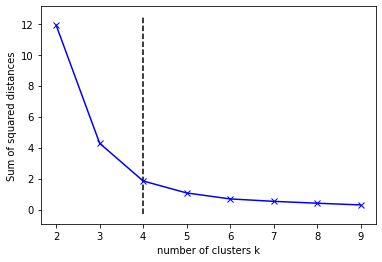

In [ ]:

x = [i for i in range(2,Kmax)]
y = compactness[0::]
kn = KneeLocator(x, y, curve='convex', direction='decreasing')
print(kn.knee)

K_knee = kn.knee

import matplotlib.pyplot as plt
plt.xlabel('number of clusters k')
plt.ylabel('Sum of squared distances')
plt.plot(x, y, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

In [ ]:
print(K_knee)

4


In [ ]:
K= K_knee


km = KMeans(n_clusters=K, random_state=0).fit(Z)
label = km.labels_.reshape(-1,1)
res = []
res2 = []
for i in range(K):
  res.append(Z[label.flatten() == i])
  res2.append(np.argwhere(label.flatten() == i))

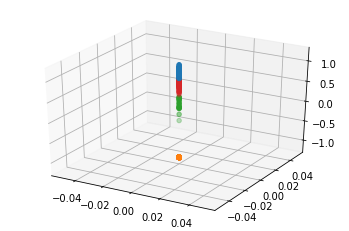

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d') 
for i in range(K):
  ax.scatter(res[i][:, 1], res[i][:, 2], res[i][:, 0])

In [ ]:
res_fusion = {}
res_fusion["K"] = K-1
res_fusion["mean"] = np.zeros((K,1))
res_fusion["size"] = np.sum(nouvelle_cartographie != 0)
res_fusion["pop"] = np.zeros((K,1))

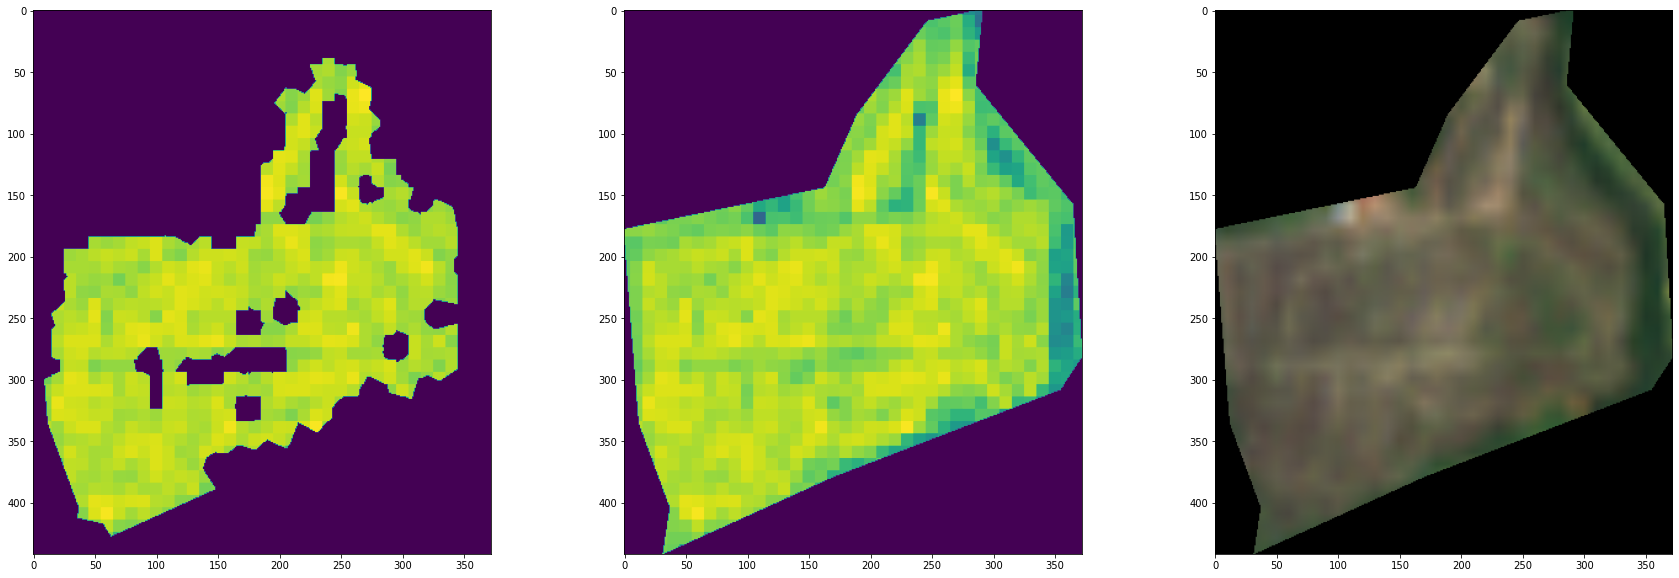

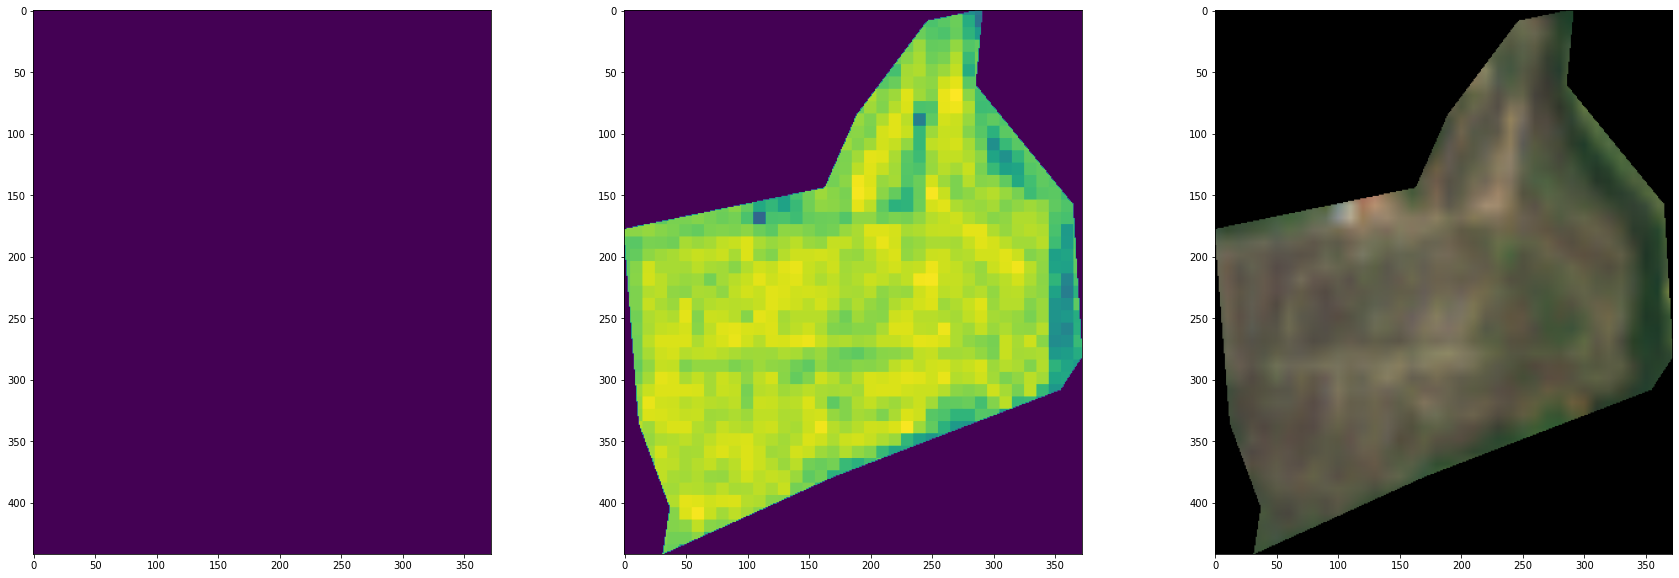

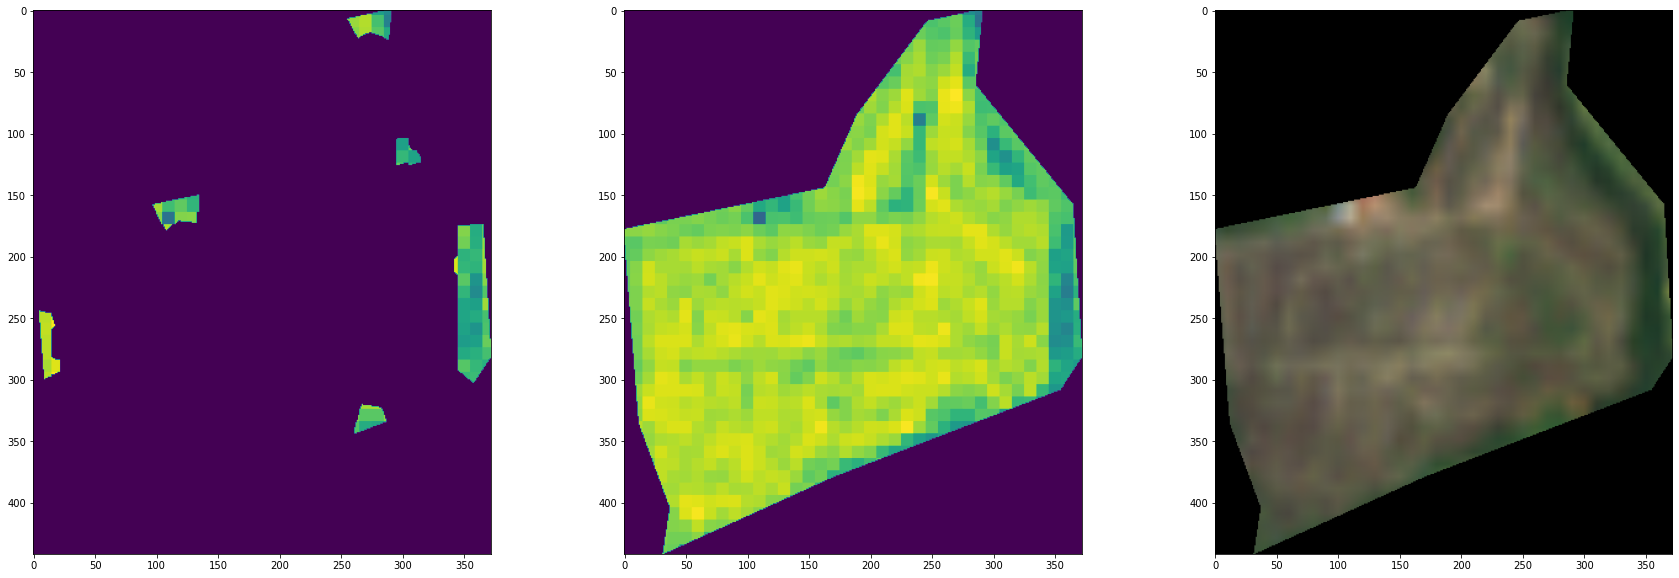

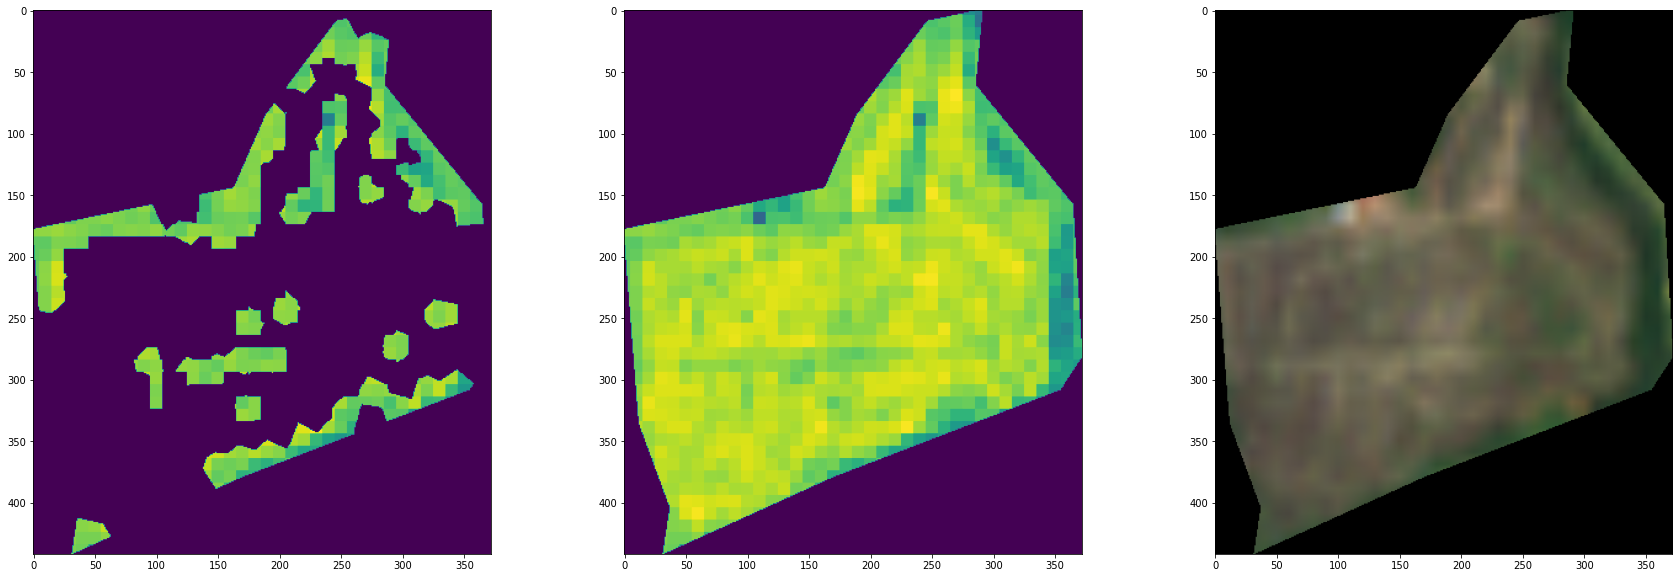

In [ ]:
final = np.zeros(nouvelle_cartographie.shape)
den_crop_img = crop_img["RGB"]
comp = 0
for b in res2:
  a = np.zeros(nouvelle_cartographie.shape)
  b = b.flatten()
  moy = np.zeros(len(b))
  for i in range(0, len(b)):
    a[labels == b[i]] = nouvelle_cartographie[labels == b[i]]
    moy[i] = nouvelle_cartographie[labels == b[i]].mean()
  for i in range(0, len(b)):
    if nouvelle_cartographie[labels == b[i]].mean() != 0:
      res_fusion["pop"][comp, 0] = res_fusion["pop"][comp, 0] + np.sum(labels == b[i])
    final[labels == b[i]] = moy.mean() 
    
    res_fusion["mean"][comp, 0] = moy.mean()
  
  a = np.uint8(a)
  plt.figure(figsize=(30,10))
  plt.subplot(1,3,1)
  plt.imshow(a)
  plt.subplot(1,3,2)
  plt.imshow(nouvelle_cartographie)
  plt.subplot(1,3,3)
  plt.imshow(den_crop_img)
  comp = comp+1



(442, 372)


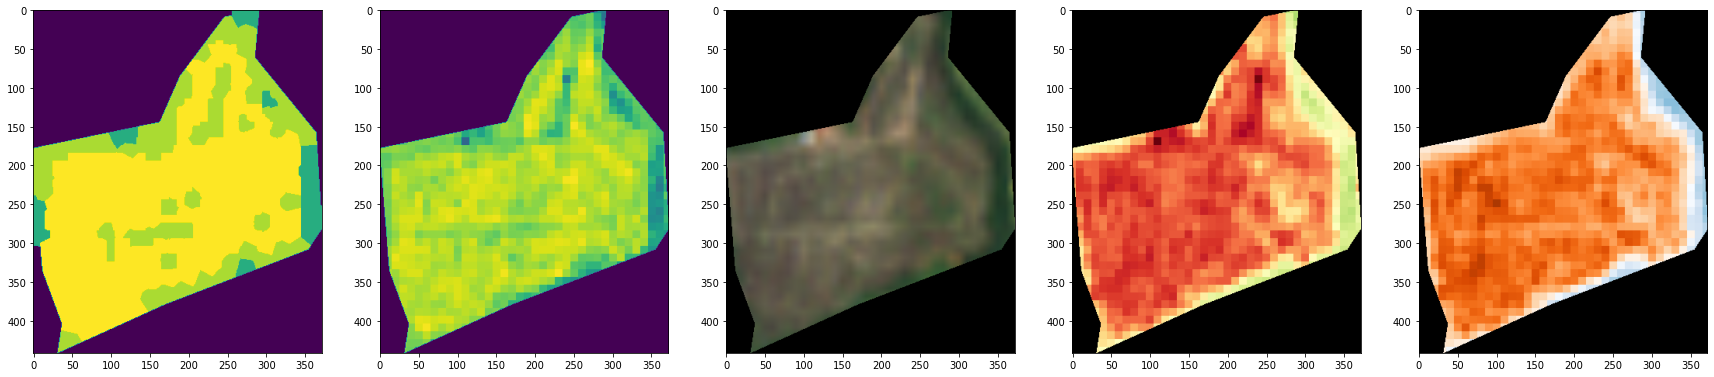

In [ ]:
  plt.figure(figsize=(30,10))
  final = np.uint8(final)
  print(final.shape)
  plt.subplot(1,5,1)
  plt.imshow(final)
  plt.subplot(1,5,2)
  plt.imshow(nouvelle_cartographie)
  plt.subplot(1,5,3)
  plt.imshow(crop_img["RGB"])
  plt.subplot(1,5,4)
  plt.imshow(crop_img["NDVI"])
  plt.subplot(1,5,5)
  plt.imshow(crop_img["NDWI"])


In [ ]:
res_fusion["mean"]

array([[228.75517074],
       [  0.        ],
       [142.05280507],
       [199.02581676]])

In [ ]:
res_fusion["size"] 

93450

In [ ]:
res_fusion["pop"]

array([[62381.],
       [    0.],
       [ 6028.],
       [25727.]])

In [ ]:

def taux_hetero(res_fusion):
  return 1 - np.sum((np.multiply(res_fusion["mean"], res_fusion["pop"])))/(res_fusion["K"] * res_fusion["size"] * np.max(res_fusion["mean"]))

In [ ]:
taux_hetero(res_fusion)

0.6842954869742507

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score,v_measure_score


In [ ]:
km_scores= []
km_silhouette = []
vmeasure_score =[]
db_score = []
X_scaled = Z
for i in range(2,12):
    km = KMeans(n_clusters=i, random_state=0).fit(X_scaled)
    preds = km.predict(X_scaled)
    
    print("Score for number of cluster(s) {}: {}".format(i,km.score(X_scaled)))
    km_scores.append(-km.score(X_scaled))
    
    silhouette = silhouette_score(X_scaled,preds)
    km_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
    
    db = davies_bouldin_score(X_scaled,preds)
    db_score.append(db)
    print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))
    
   
    print("-"*100)

Score for number of cluster(s) 2: -11.90054702758789
Silhouette score for number of cluster(s) 2: 0.9273030161857605
Davies Bouldin score for number of cluster(s) 2: 0.08476802620944938
----------------------------------------------------------------------------------------------------
Score for number of cluster(s) 3: -4.278583526611328
Silhouette score for number of cluster(s) 3: 0.8148509860038757
Davies Bouldin score for number of cluster(s) 3: 0.41935011863721794
----------------------------------------------------------------------------------------------------
Score for number of cluster(s) 4: -1.847001552581787
Silhouette score for number of cluster(s) 4: 0.7806814908981323
Davies Bouldin score for number of cluster(s) 4: 0.3844309439946
----------------------------------------------------------------------------------------------------
Score for number of cluster(s) 5: -1.0733662843704224
Silhouette score for number of cluster(s) 5: 0.7482131123542786
Davies Bouldin score for 

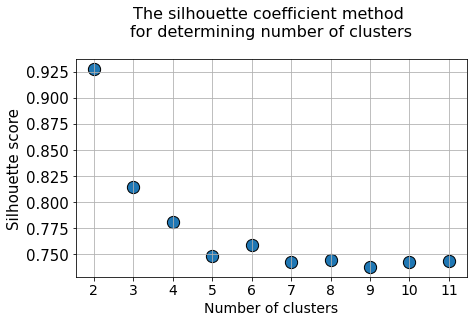

In [ ]:
plt.figure(figsize=(7,4))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=km_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

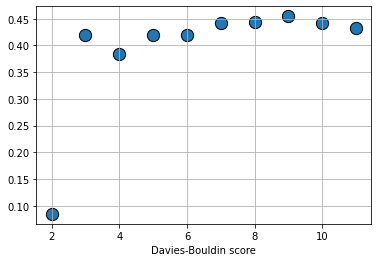

In [ ]:
plt.scatter(x=[i for i in range(2,12)],y=db_score,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Davies-Bouldin score")
plt.show()